### **Classifier experiment**

In [1]:
import os
import numpy as np
import librosa
import torch
import torchaudio
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import itertools

# Add the parent directory to the Python path
import sys
import os
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import loss function
from texstat.functions import *
from texstat.fad import *
from texstat.segmentation import *
import texstat.torch_filterbanks.filterbanks as fb

def load_embeddings(folder_path, sample_rate=44100, segment_size=2**16, num_segments=20, *args, **kwargs):
    """
    Load audio embeddings for training.

    Args:
        folder_path (str): Path to dataset with subfolders for each class.
        model_function (callable): Function to extract embeddings (must accept a raw audio segment).
        segment_size (int, optional): Size of the audio segment to extract. Defaults to 2**16.
        num_segments (int, optional): Number of segments per class. Defaults to 20.
        *args: Positional arguments to pass to model_function.
        **kwargs: Keyword arguments to pass to model_function.

    Returns:
        np.ndarray: Feature matrix (X).
        np.ndarray: One-hot encoded labels (y).
        dict: Mapping of class indices to class names.
    """
    X, y = [], []
    class_labels = {}
    for idx, class_folder in enumerate(sorted(os.listdir(folder_path))):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        class_labels[idx] = class_folder
        embeddings = extract_embeddings_from_folder(class_path, segment_size, sample_rate, segments_number=num_segments, *args, **kwargs)
        
        # Append embeddings to X
        X.append(embeddings)

        # Append corresponding label (idx) for each segment to y
        y.extend([idx] * num_segments)  # Add 'num_segments' times the class index for each segment

    # Convert X to a numpy array
    X = np.vstack(X)  # Stack the list of arrays into a single 2D array

    # Convert y to a numpy array and reshape
    y = np.array(y).reshape(-1, 1)

    # One-hot encode the labels
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(y)

    return X, y, class_labels

def train_and_evaluate_mlp(X, y, class_labels, test_size=0.2, random_seed=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    
    classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, solver='adam')
    classifier.fit(X_train, np.argmax(y_train, axis=1))
    
    y_pred = classifier.predict(X_test)
    y_test_labels = np.argmax(y_test, axis=1)
    
    # Accuracy
    print("Accuracy:", accuracy_score(y_test_labels, y_pred))
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred, target_names=[class_labels[i] for i in class_labels]))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Extract class names as a list
    class_names = [class_labels[i] for i in range(len(class_labels))]

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return classifier


### **1. TexStat Classification**

### **1.1. Boreillysegmented16K Class**

Processing folder: arp
Found 840 files in ../../MicroTex/boreillysegmented16K_class/arp
    Segmented 1 segments from ../../MicroTex/boreillysegmented16K_class/arp/arp_3--v-135.wav
    Segmented 1 segments from ../../MicroTex/boreillysegmented16K_class/arp/arp_12--v-32.wav
    Segmented 1 segments from ../../MicroTex/boreillysegmented16K_class/arp/arp_10--v-10.wav
    Segmented 1 segments from ../../MicroTex/boreillysegmented16K_class/arp/arp_10--v-85.wav
    Segmented 1 segments from ../../MicroTex/boreillysegmented16K_class/arp/arp_3--v-167.wav
    Segmented 1 segments from ../../MicroTex/boreillysegmented16K_class/arp/arp_10--v-8.wav
    Segmented 1 segments from ../../MicroTex/boreillysegmented16K_class/arp/arp_3--v-90.wav
    Segmented 1 segments from ../../MicroTex/boreillysegmented16K_class/arp/arp_2--v-72.wav
    Segmented 1 segments from ../../MicroTex/boreillysegmented16K_class/arp/arp_10--v-55.wav
    Segmented 1 segments from ../../MicroTex/boreillysegmented16K_class/arp/ar

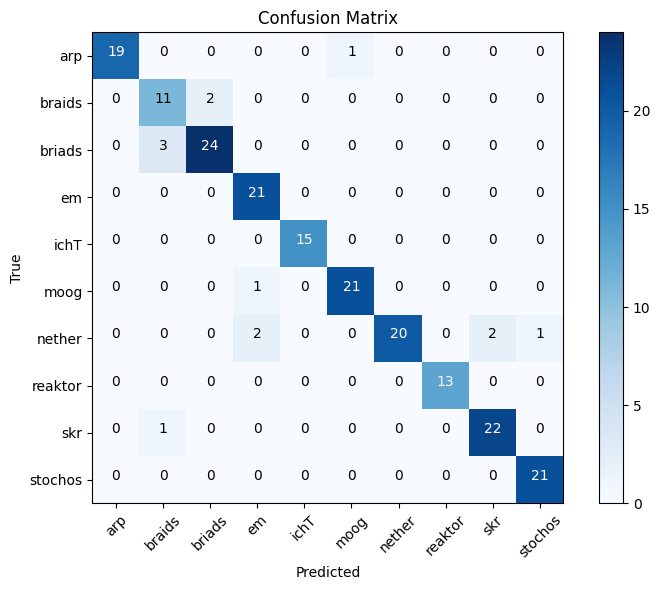

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)

In [2]:
# Stats parameters
sr            = 44100
frame_size    = 44099
N_filter_bank = 16
M_filter_bank = 6 
N_moments     = 4
alpha         = torch.tensor([10, 1, 1/10, 1/100])
beta          = torch.tensor([1, 1, 1, 1, 1])
new_sr, new_frame_size = sr // 4, frame_size // 4 # for downsampler
downsampler = torchaudio.transforms.Resample(sr, new_sr)
coch_fb = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
mod_fb  = fb.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)

# Embeddings computation for dataset
X, y, class_labels = load_embeddings(
    folder_path="../../MicroTex/boreillysegmented16K_class/",
    sample_rate =sr,
    segment_size=frame_size, 
    num_segments=100, # model parameters from here
    coch_fb=coch_fb,
    mod_fb=mod_fb,
    downsampler=downsampler,
    N_moments=N_moments,
    alpha=alpha
)

train_and_evaluate_mlp(X, y, class_labels, test_size=0.2, random_seed=42)

### **1.2. Freesound Class**

Processing folder: bubbles
Found 2 files in ../../MicroTex/freesound_class/bubbles
    Segmented 59 segments from ../../MicroTex/freesound_class/bubbles/bubbles_short_extended.wav
    Segmented 242 segments from ../../MicroTex/freesound_class/bubbles/bubbles_long.wav
Total segments: 301
Selected 100 segments after random selection
Processed 100 segments in ../../MicroTex/freesound_class/bubbles
Processing folder: fire
Found 1 files in ../../MicroTex/freesound_class/fire
    Segmented 191 segments from ../../MicroTex/freesound_class/fire/fire_augmented.wav
Total segments: 191
Selected 100 segments after random selection
Processed 100 segments in ../../MicroTex/freesound_class/fire
Processing folder: keyboard
Found 3 files in ../../MicroTex/freesound_class/keyboard
    Segmented 38 segments from ../../MicroTex/freesound_class/keyboard/keyboard_ceramic.wav
    Segmented 183 segments from ../../MicroTex/freesound_class/keyboard/keyboard_mechanic.wav
    Segmented 27 segments from ../../Mic

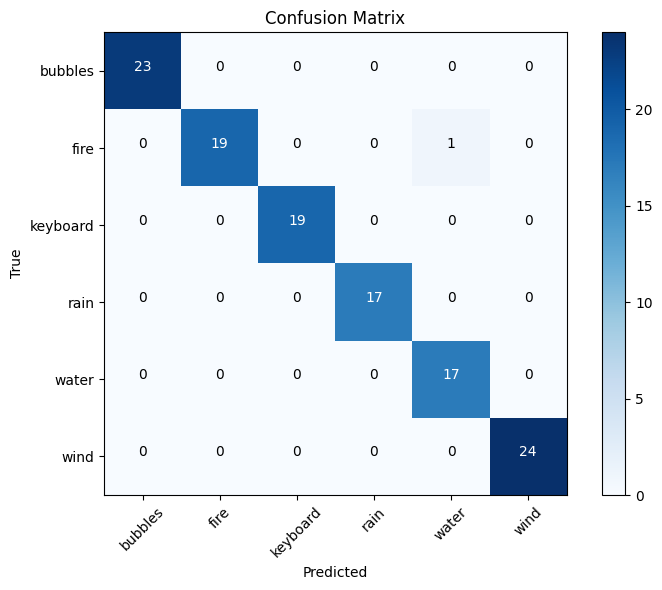

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)

In [3]:
# Stats parameters
sr            = 44100
frame_size    = 44099
N_filter_bank = 16
M_filter_bank = 6
N_moments     = 4
alpha         = torch.tensor([10, 1, 1/10, 1/100])
beta          = torch.tensor([1, 1, 1, 1, 1])
new_sr, new_frame_size = sr // 4, frame_size // 4 # for downsampler
downsampler = torchaudio.transforms.Resample(sr, new_sr)
coch_fb = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
mod_fb  = fb.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)

# Embeddings computation for dataset
X, y, class_labels = load_embeddings(
    folder_path="../../MicroTex/freesound_class/",
    sample_rate =sr,
    segment_size=frame_size, 
    num_segments=100,
    coch_fb=coch_fb,
    mod_fb=mod_fb,
    downsampler=downsampler,
    N_moments=N_moments,
    alpha=alpha
)

train_and_evaluate_mlp(X, y, class_labels, test_size=0.2, random_seed=42)

### **1.3. Syntex dataset**

Processing folder: applause
Found 77 files in ../../MicroTex/syntex_class/applause
    Segmented 2 segments from ../../MicroTex/syntex_class/applause/DSApplause--numClappers_exp-00.70--rate_exp-00.67.wav
    Segmented 2 segments from ../../MicroTex/syntex_class/applause/DSApplause--numClappers_exp-00.10--rate_exp-00.50.wav
    Segmented 2 segments from ../../MicroTex/syntex_class/applause/DSApplause--numClappers_exp-00.60--rate_exp-00.83.wav
    Segmented 2 segments from ../../MicroTex/syntex_class/applause/DSApplause--numClappers_exp-00.60--rate_exp-00.67.wav
    Segmented 2 segments from ../../MicroTex/syntex_class/applause/DSApplause--numClappers_exp-00.80--rate_exp-00.67.wav
    Segmented 2 segments from ../../MicroTex/syntex_class/applause/DSApplause--numClappers_exp-00.60--rate_exp-01.00.wav
    Segmented 2 segments from ../../MicroTex/syntex_class/applause/DSApplause--numClappers_exp-01.00--rate_exp-00.00.wav
    Segmented 2 segments from ../../MicroTex/syntex_class/applause/DSA

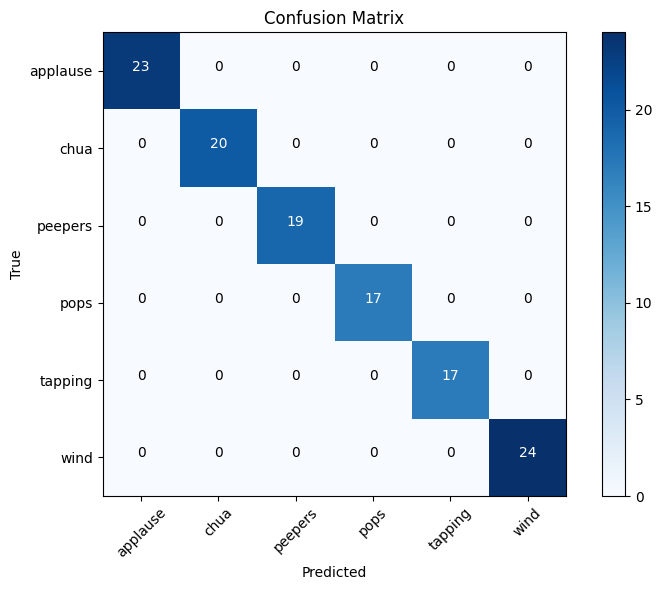

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)

In [4]:
# Stats parameters
sr            = 44100
frame_size    = 44099
N_filter_bank = 16
M_filter_bank = 6
N_moments     = 4
alpha         = torch.tensor([10, 1, 1/10, 1/100])
beta          = torch.tensor([1, 1, 1, 1, 1])
new_sr, new_frame_size = sr // 4, frame_size // 4 # for downsampler
downsampler = torchaudio.transforms.Resample(sr, new_sr)
coch_fb = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
mod_fb  = fb.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)

# Embeddings computation for dataset
X, y, class_labels = load_embeddings(
    folder_path="../../MicroTex/syntex_class/",
    sample_rate =sr,
    segment_size=frame_size, 
    num_segments=100,
    coch_fb=coch_fb,
    mod_fb=mod_fb,
    downsampler=downsampler,
    N_moments=N_moments,
    alpha=alpha
)

train_and_evaluate_mlp(X, y, class_labels, test_size=0.2, random_seed=42)